<a href="https://colab.research.google.com/github/Pratham078/NLP/blob/main/Multilingual_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=f2e76db8911733b2313cbcca34521157f839d12c2fcda6a6b15d4dcde5226610
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
import spacy # fast NLP
import pandas as pd # dataframes
import langid # language identification (i.e. what language is this?)
#from nltk.classify.textcat import TextCat # language identification from NLTK
from matplotlib.pyplot import plot

In [ ]:
# read in our data
data = pd.read_csv("/content/all_annotated.tsv", sep = "\t")

In [ ]:
data.head()

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets
0,434215992731136000,TR,2014-02-14,Bugün bulusmami lazimdiii,0,0,1,0,0,0
1,285903159434563584,TR,2013-01-01,Volkan konak adami tribe sokar yemin ederim :D,0,0,1,0,0,0
2,285948076496142336,NL,2013-01-01,Bed,1,0,0,0,0,0
3,285965965118824448,US,2013-01-01,I felt my first flash of violence at some fool...,1,0,0,0,0,0
4,286057979831275520,US,2013-01-01,Ladies drink and get in free till 10:30,1,0,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10502 entries, 0 to 10501
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Tweet ID                         10502 non-null  int64 
 1   Country                          10492 non-null  object
 2   Date                             10502 non-null  object
 3   Tweet                            10502 non-null  object
 4   Definitely English               10502 non-null  int64 
 5   Ambiguous                        10502 non-null  int64 
 6   Definitely Not English           10502 non-null  int64 
 7   Code-Switched                    10502 non-null  int64 
 8   Ambiguous due to Named Entities  10502 non-null  int64 
 9   Automatically Generated Tweets   10502 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 820.6+ KB


In [ ]:
data.isnull().sum()

Tweet ID                            0
Country                            10
Date                                0
Tweet                               0
Definitely English                  0
Ambiguous                           0
Definitely Not English              0
Code-Switched                       0
Ambiguous due to Named Entities     0
Automatically Generated Tweets      0
dtype: int64

In [ ]:
data.columns

Index(['Tweet ID', 'Country', 'Date', 'Tweet', 'Definitely English',
       'Ambiguous', 'Definitely Not English', 'Code-Switched',
       'Ambiguous due to Named Entities', 'Automatically Generated Tweets'],
      dtype='object')

In [ ]:
text_df = data.drop(['Tweet ID', 'Country', 'Date', 'Definitely English', 'Ambiguous',
       'Definitely Not English', 'Code-Switched', 'Ambiguous due to Named Entities', 'Automatically Generated Tweets',], axis=1)
text_df.head()

,Tweet
0,Bugün bulusmami lazimdiii
1,Volkan konak adami tribe sokar yemin ederim :D
2,Bed
3,I felt my first flash of violence at some fool...
4,Ladies drink and get in free till 10:30


In [ ]:
print(text_df['Tweet'].iloc[0],"\n")
print(text_df['Tweet'].iloc[1],"\n")
print(text_df['Tweet'].iloc[2],"\n")
print(text_df['Tweet'].iloc[3],"\n")
print(text_df['Tweet'].iloc[4],"\n")

Bugün bulusmami lazimdiii 

Volkan konak adami tribe sokar yemin ederim :D 

Bed 

I felt my first flash of violence at some fool who bumped into me.... I pity the fool. 

Ladies drink and get in free till 10:30 



In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10502 entries, 0 to 10501
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   10502 non-null  object
dtypes: object(1)
memory usage: 82.2+ KB


In [ ]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [ ]:
text_df.Tweet = text_df['Tweet'].apply(data_processing)

In [ ]:
text_df = text_df.drop_duplicates('Tweet')

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [ ]:
text_df['Tweet'] = text_df['Tweet'].apply(lambda x: stemming(x))

In [ ]:
text_df.head()

,Tweet
0,bugün bulusmami lazimdiii
1,volkan konak adami tribe sokar yemin ederim
2,bed
3,felt first flash violence fool bumped pity fool
4,ladies drink get free till 1030


In [ ]:
print(text_df['Tweet'].iloc[0],"\n")
print(text_df['Tweet'].iloc[1],"\n")
print(text_df['Tweet'].iloc[2],"\n")
print(text_df['Tweet'].iloc[3],"\n")
print(text_df['Tweet'].iloc[4],"\n")

bugün bulusmami lazimdiii 

volkan konak adami tribe sokar yemin ederim 

bed 

felt first flash violence fool bumped pity fool 

ladies drink get free till 1030 



In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10463 entries, 0 to 10501
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   10463 non-null  object
dtypes: object(1)
memory usage: 163.5+ KB


In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

# Load the sentiment analysis pipeline for XLM-RoBERTa
sentiment_analysis = pipeline("sentiment-analysis", model="xlm-roberta-base")

# Assuming 'text' is the column containing the text data
for index, row in text_df.iterrows():
    text = row['Tweet']
    result = sentiment_analysis(text, top_k=1)

    # Extracting the top result's polarity score
    polarity = result[0]['score']

    # Assigning polarity back to DataFrame
    text_df.at[index, 'polarity'] = polarity

# Displaying the updated DataFrame with polarity scores
print(text_df[['Tweet', 'polarity']])


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

                                                   Tweet  polarity
0                              bugün bulusmami lazimdiii  0.555726
1            volkan konak adami tribe sokar yemin ederim  0.557426
2                                                    bed  0.556624
3        felt first flash violence fool bumped pity fool  0.555974
4                        ladies drink get free till 1030  0.559797
...                                                  ...       ...
10497  im piazzaavym canik samsun w mertarmann debea5...  0.561356
10498  el nido fica ao norte de palawan uma das ilhas...  0.557484
10499  alhamdulillah makasih mah pah lovyu terras kot...  0.556482
10500                   eidmubarak bauchi fedral lowcost  0.557021
10501  ⒍ santa catarina pinulan⒎ nairo quintanan⒏ ana...  0.562324

[10463 rows x 2 columns]


In [ ]:
text_df.head(10)

,Tweet,polarity
0,bugün bulusmami lazimdiii,0.555726
1,volkan konak adami tribe sokar yemin ederim,0.557426
2,bed,0.556624
3,felt first flash violence fool bumped pity fool,0.555974
4,ladies drink get free till 1030,0.559797
5,melanynijholtxo ahhahahahah dm,0.556169
6,fuck,0.552303
7,watching miranda bbc1 mermhart u r hilarious,0.551336
8,stizzsti fino,0.554910
9,shopping kohls httptcoi8zkqht9,0.561184


from matplotlib import pyplot as plt
_df_0['polarity'].plot(kind='hist', bins=20, title='polarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['polarity'].plot(kind='line', figsize=(8, 4), title='polarity')
plt.gca().spines[['top', 'right']].set_visible(False)

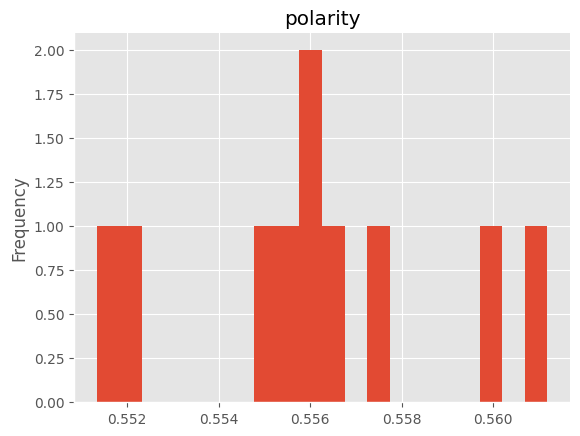

In [ ]:
from matplotlib import pyplot as plt
_df_0['polarity'].plot(kind='hist', bins=20, title='polarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

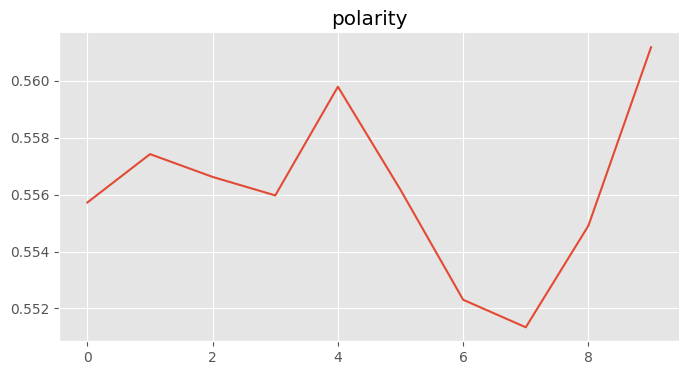

In [ ]:
from matplotlib import pyplot as plt
_df_1['polarity'].plot(kind='line', figsize=(8, 4), title='polarity')
plt.gca().spines[['top', 'right']].set_visible(False)

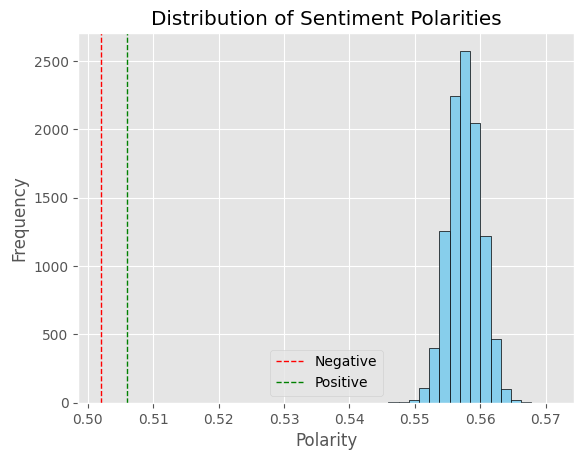

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'text_df' contains the polarity column
polarity_values = text_df['polarity']

# Creating a histogram to visualize polarity distribution
plt.hist(polarity_values, bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarities')

# Adding lines for neutral, positive, and negative sentiment ranges (adjust these thresholds based on your dataset)
plt.axvline(x=0.502, color='red', linestyle='dashed', linewidth=1, label='Negative')
plt.axvline(x=0.506, color='green', linestyle='dashed', linewidth=1, label='Positive')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Finding the index of the entry with the maximum polarity score
max_polarity_index = text_df['polarity'].idxmax()

# Retrieving the text with the maximum polarity score
text_with_max_polarity = text_df.loc[max_polarity_index, 'Tweet']

# Retrieving the maximum polarity score itself
max_polarity = text_df.loc[max_polarity_index, 'polarity']

print(f"Text with maximum polarity: '{text_with_max_polarity}'")
print(f"Maximum polarity score: {max_polarity}")


Text with maximum polarity: 'なにこれn ヽn n 丶 n 丶 n 丶n f n 一 n ヽ ノn 丿ﾉ ﾉ丁丁ln く__lノ'
Maximum polarity score: 0.5709389448165894


In [ ]:
# Finding the index of the entry with the maximum polarity score
min_polarity_index = text_df['polarity'].idxmin()

# Retrieving the text with the maximum polarity score
text_with_min_polarity = text_df.loc[min_polarity_index, 'Tweet']

# Retrieving the maximum polarity score itself
min_polarity = text_df.loc[min_polarity_index, 'polarity']

print(f"Text with minimum polarity: '{text_with_min_polarity}'")
print(f"Minimum polarity score: {min_polarity}")


Text with minimum polarity: 'nak travel'
Minimum polarity score: 0.524056613445282


In [ ]:
def assign_sentiment_label(score):
    if score >= 0.52 and score < 0.55:
        return 'Negative'
    elif score >= 0.55 and score < 0.557:
        return 'Neutral'
    elif score >= 0.557 and score <= 0.6:
        return 'Positive'
    else:
        return 'Undefined'  # Handle scores outside the specified ranges

# Assuming 'text_df' contains a column 'polarity' with polarity scores
text_df['sentiment'] = text_df['polarity'].apply(assign_sentiment_label)

# Displaying the DataFrame with assigned sentiment labels
print(text_df[['Tweet', 'polarity', 'sentiment']])


                                                   Tweet  polarity sentiment
0                              bugün bulusmami lazimdiii  0.555726   Neutral
1            volkan konak adami tribe sokar yemin ederim  0.557426  Positive
2                                                    bed  0.556624   Neutral
3        felt first flash violence fool bumped pity fool  0.555974   Neutral
4                        ladies drink get free till 1030  0.559797  Positive
...                                                  ...       ...       ...
10497  im piazzaavym canik samsun w mertarmann debea5...  0.561356  Positive
10498  el nido fica ao norte de palawan uma das ilhas...  0.557484  Positive
10499  alhamdulillah makasih mah pah lovyu terras kot...  0.556482   Neutral
10500                   eidmubarak bauchi fedral lowcost  0.557021  Positive
10501  ⒍ santa catarina pinulan⒎ nairo quintanan⒏ ana...  0.562324  Positive

[10463 rows x 3 columns]


<Axes: xlabel='sentiment', ylabel='count'>

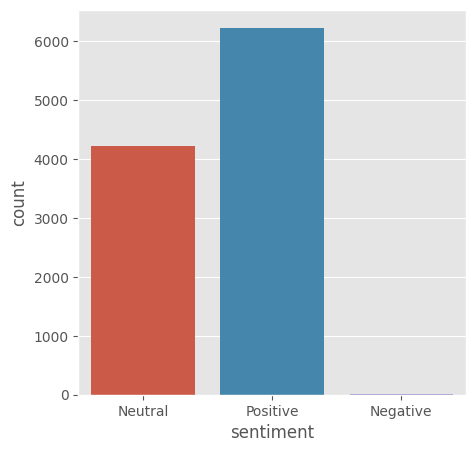

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

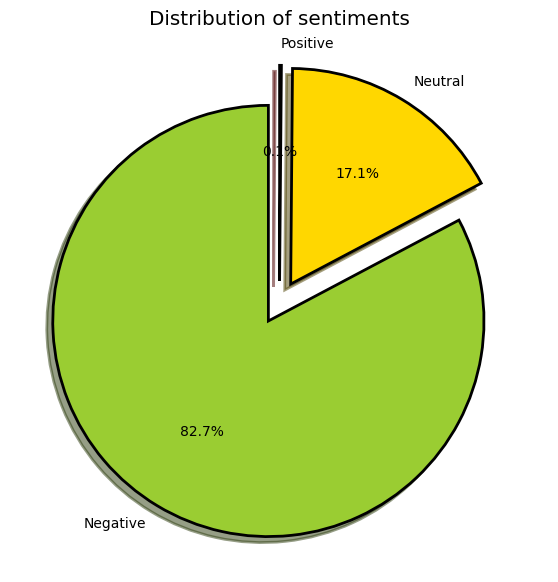

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [ ]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,Tweet,polarity,sentiment
98,なにこれn ヽn n 丶 n 丶 n 丶n f n 一 n ヽ ノn 丿ﾉ ﾉ丁丁ln く__lノ,0.570939,Positive
3110,its_meezybtw douordie_ trent_ungard ctfu idk game,0.566892,Positive
3151,toriannaaa lmao responsible rt kvese_ im schle...,0.566830,Positive
707,bourbon st amp bienville st httptcotrqufxbjoi,0.566229,Positive
9252,tall people københavn cph instacph copenhagen ...,0.565827,Positive


In [ ]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,Tweet,polarity,sentiment
8960,perpus faperta upt indomartkostan latepost sra...,0.559997,Negative
4390,patzy_macedo catch every day,0.559996,Negative
7675,aig customer service contact center rep housto...,0.559996,Negative
4215,ah ben ah httptcoiwpxrqbhaz,0.559996,Negative
2519,あそーいやきょぺたんnn今日ヘルプで白くんきてたよーん,0.559994,Negative


In [ ]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,Tweet,polarity,sentiment
761,im dois toques f são paulo são pauko httptcoaz...,0.564969,Neutral
3607,en france งานสปดาหหนงสอแหงชาตครงท42 ศนยการประช...,0.564969,Neutral
2063,wod zoostrength zoostrength hq httptcocxvztpris6,0.564861,Neutral
3954,im трц эльград электросталь московская обл w 2...,0.564843,Neutral
5472,vezes vem umas ideias que eu acho que só eu te...,0.564842,Neutral


In [ ]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['Tweet'])

In [ ]:
feature_names = np.array(vect.get_feature_names_out())
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 94945

First 20 features:
 ['00' '00 baro101133' '00 kmh' '00 mm' '00 mmhr' '00 mmnhumidity' '000'
 '000 humidity' '000 nous' '0000mm' '0000mm vent' '000935kgkgda'
 '000935kgkgda 5323' '000in' '001' '001 waynesboro' '00660' '00660 mucha'
 '007' '007 humidity']


In [ ]:
X = text_df['Tweet']
Y = text_df['sentiment']
X = vect.transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (8370, 94945)
Size of y_train: (8370,)
Size of x_test: (2093, 94945)
Size of y_test: (2093,)


In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 83.09%


In [ ]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[1730    7    0]
 [ 344    9    0]
 [   3    0    0]]


              precision    recall  f1-score   support

    Negative       0.83      1.00      0.91      1737
     Neutral       0.56      0.03      0.05       353
    Positive       0.00      0.00      0.00         3

    accuracy                           0.83      2093
   macro avg       0.47      0.34      0.32      2093
weighted avg       0.79      0.83      0.76      2093



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 0.1}


In [ ]:
y_pred = grid.predict(x_test)

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 82.94%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1734    3    0]
 [ 351    2    0]
 [   3    0    0]]


              precision    recall  f1-score   support

    Negative       0.83      1.00      0.91      1737
     Neutral       0.40      0.01      0.01       353
    Positive       0.00      0.00      0.00         3

    accuracy                           0.83      2093
   macro avg       0.41      0.33      0.31      2093
weighted avg       0.76      0.83      0.75      2093



In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [ ]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 82.85%


In [ ]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[1722   15    0]
 [ 341   12    0]
 [   3    0    0]]


              precision    recall  f1-score   support

    Negative       0.83      0.99      0.91      1737
     Neutral       0.44      0.03      0.06       353
    Positive       0.00      0.00      0.00         3

    accuracy                           0.83      2093
   macro avg       0.43      0.34      0.32      2093
weighted avg       0.77      0.83      0.76      2093



In [ ]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 0.001}


In [ ]:
y_pred = grid.predict(x_test)

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 82.99%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1737    0    0]
 [ 353    0    0]
 [   3    0    0]]


              precision    recall  f1-score   support

    Negative       0.83      1.00      0.91      1737
     Neutral       0.00      0.00      0.00       353
    Positive       0.00      0.00      0.00         3

    accuracy                           0.83      2093
   macro avg       0.28      0.33      0.30      2093
weighted avg       0.69      0.83      0.75      2093

